In [36]:
import utils.irutilities as irutil
from pathlib import Path
import librosa
import numpy as np
import matplotlib.pyplot as plt

path = Path('mesh_rir/S32-M441_npy/')
print('Loading IRs ...')
posMic, posSrc, ir = irutil.loadIR(path)

samplerate = 48000

s = 0
m = 32
sample = ir[s,m,:]



Loading IRs ...


(1025, 65)


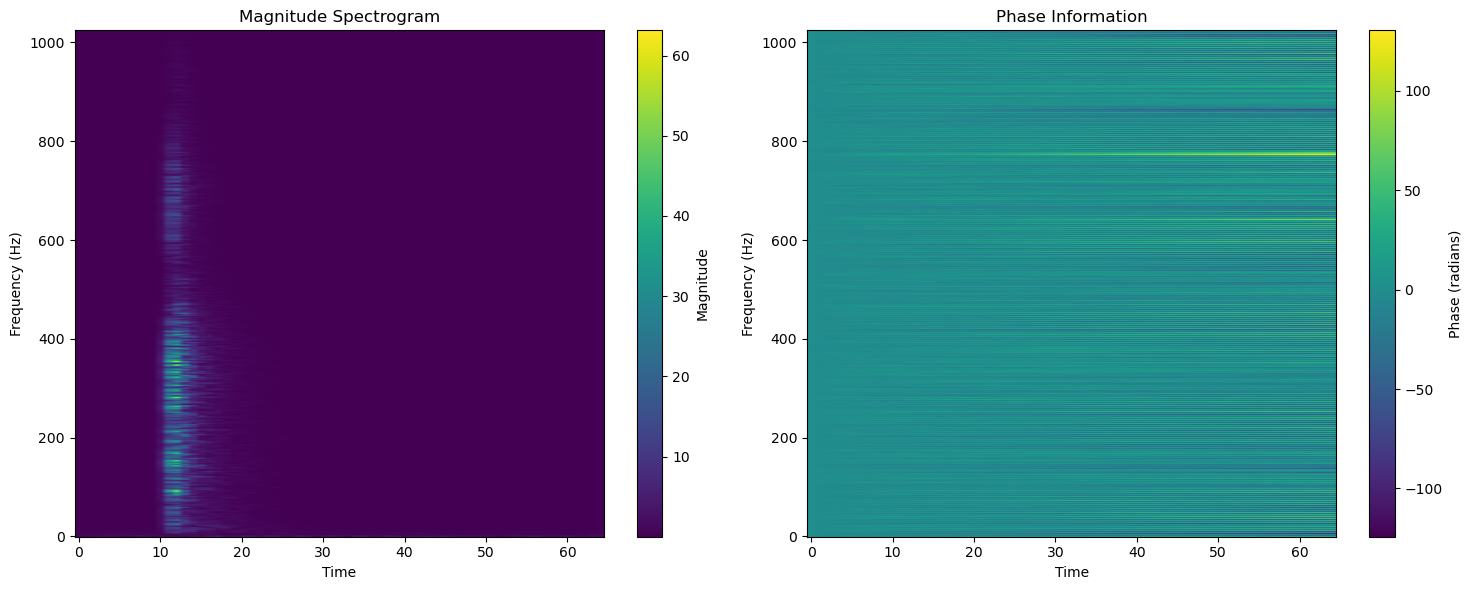

In [37]:
# Calculate the magnitude spectrogram and phase
data = np.abs(librosa.stft(sample, n_fft=2048, hop_length=512))
phase = np.angle(librosa.stft(sample, n_fft=2048, hop_length=512))
phase = np.unwrap(phase)/180
print(phase.shape)

# Reconstruct the audio signal for visualization (optional)
result = librosa.istft(data * np.exp(1j * phase), hop_length=512)

# Create a figure with two subplots
plt.figure(figsize=(15, 6))

# Plot the magnitude spectrogram on the left
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='viridis', aspect='auto')
plt.colorbar(label='Magnitude')
plt.title("Magnitude Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.gca().invert_yaxis()

# Plot the phase information on the right
plt.subplot(1, 2, 2)
plt.imshow(phase, cmap='viridis', aspect='auto')
plt.colorbar(label='Phase (radians)')
plt.title("Phase Information")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.gca().invert_yaxis()

# Add space between the subplots
plt.tight_layout()

# Save the combined plot as an image
#plt.savefig('spectrogram_with_phase.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


MSE 3.595719730442355e-33


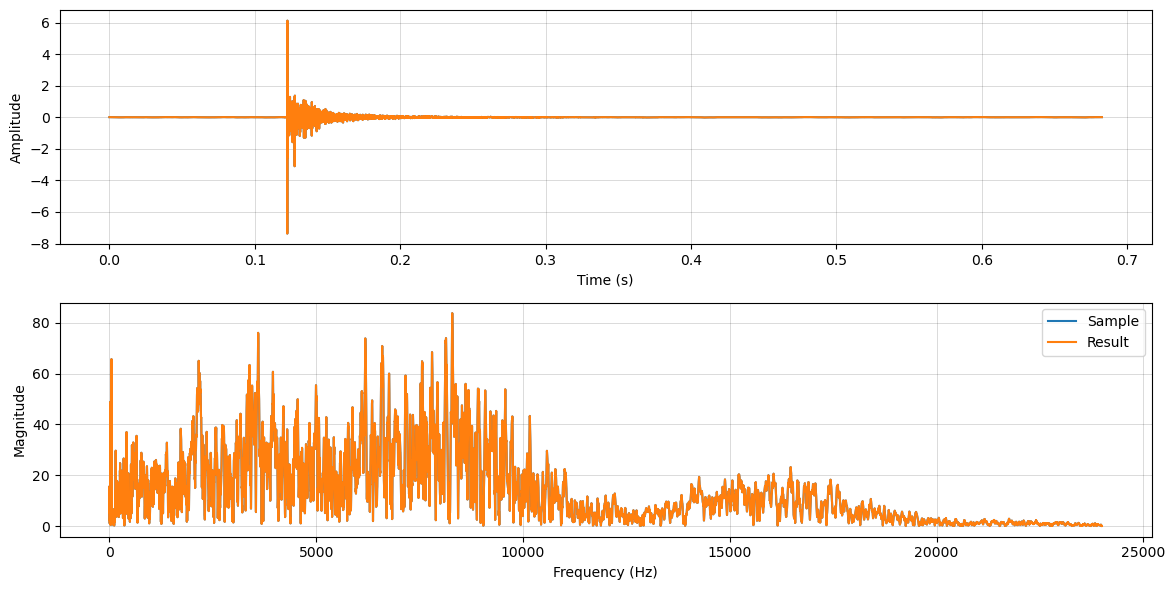

In [38]:
print("MSE", np.mean((sample - result) ** 2))

# Time domain plot
t = np.arange(sample.shape[0]) / samplerate
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.subplot(2, 1, 1)  # Create a subplot for the time domain waveform of 'sample'
plt.plot(t, sample, label='Sample')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.grid(True, linestyle='-', linewidth=0.5, color='black', alpha=0.2)

# Frequency domain plot (FFT - one side) for 'sample'
fft_result_sample = np.fft.fft(sample)
freq_sample = np.fft.fftfreq(len(sample), 1.0 / samplerate)
half_n = len(sample) // 2  # Only plot one side, assuming real input

plt.subplot(2, 1, 2)  # Create a subplot for the frequency domain plot of 'sample'
plt.plot(freq_sample[:half_n], np.abs(fft_result_sample[:half_n]), label='Sample')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.grid(True, linestyle='-', linewidth=0.5, color='black', alpha=0.2)

# Plot 'result' on the same time domain and frequency domain plots
t_result = np.arange(result.shape[0]) / samplerate

plt.subplot(2, 1, 1)  # Reuse the top subplot for 'result'
plt.plot(t_result, result, label='Result')

plt.subplot(2, 1, 2)  # Reuse the bottom subplot for 'result'
fft_result_result = np.fft.fft(result)
plt.plot(freq_sample[:half_n], np.abs(fft_result_result[:half_n]), label='Result')

# Add legends to distinguish 'sample' and 'result'
plt.legend()

# Save the figure with both plots
plt.tight_layout()
#plt.savefig('ir_amplitude_and_fft_one_side.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import torch

from network import NAF
from sound_loader import sound_samples

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Loading dataset. It might take a while ...')
dataset = sound_samples(num_samples=20)

src = torch.tensor(dataset.posSrc[s, :]).unsqueeze(1).to(device)
mic = torch.tensor(dataset.posMic[m, :]).unsqueeze(1).to(device)

# Load NAF with selected configuration
net = NAF(input_dim = 416, min_xy=dataset.min_pos[:2], max_xy=dataset.max_pos[:2]).to(device)
state_dict = torch.load('saved/net_20230830_141755_loss_0.0455.pth')
net.load_state_dict(state_dict)
net.eval()

start_time = time.time()
out = net.spectrogram_at(src, mic)
exec_time = time.time() - start_time
print(exec_time)
out = (out * dataset.std) + dataset.mean